In [10]:
#The is a header kernel
from pandas_datareader import data
import matplotlib.pyplot as plt 
import pandas as pd
import datetime as dtt
import math
import numpy as np
from datetime import date as dt
from scipy import stats
import sqlite3
import time

class Date_price(): ##Store info for a single day
    def __init__ (self, date, price, Nth_day):
        self.date=date
        self.price=price
        self.Nth_day=Nth_day

class Date_price_list(): ##Store info for a period of day
    def __init__ (self, panel_data, start_date, end_date):
        self.len_period = len(panel_data['Open'])
        self.one_day_info=[]
        for x in range(0, self.len_period):
            tmp=Date_price(start_date+dtt.timedelta(days=x), panel_data['Open'][x], x)
            self.one_day_info.append(tmp)
        self.date_x=[]
        self.price_y=[]
        for i in range (0, len(self.one_day_info)):
            self.date_x.append(self.one_day_info[i].Nth_day)
            self.price_y.append(self.one_day_info[i].price)
        
class Graph_plot(): #Used to plot types of statistic graph transferred from default file
    def __init__ (self, data_source, func):
        pass
            
    def default(self):
        plt.plot(data_source.date_x, data_source.price_y)
    
    def liner_regression(self):
        plt.plot(func.graph_x_LR, func.graph_y_LR)
        
    def fo_trans(self):
        plt.plot(func.xf, func.yf_abs)
        plt.grid()
        plt.show()

class Index_func(): #Store types of functions to generate new figures from default graphs
    def __init__ (self, data_source):
        self.delta_y=[0]
        self.graph_x_LR=[]
        self.graph_y_LR=[]
        self.xf=[]
        self.yf_abs=[]
    
    def Delta_y(self):
        for i in range (1, len(data_source.price_y)):
            self.delta_y.append(data_source.price_y[i]-data_source.price_y[i-1])
        
    def linear_regression(self, show_fitness_index=False, x=[], y=[]):
        if (len(x)==0):
            x=data_source.date_x
            y=data_source.price_y
        sum_numerator=0
        sum_denominator=0
        graph_x_mean=np.mean(x)
        graph_y_mean=np.mean(y)
        for i in range(0, len(x)):
            sum_numerator+=(x[i]-graph_x_mean)*(y[i]-graph_y_mean)
            sum_denominator+=(x[i]-graph_x_mean)**2
        b1=sum_numerator/sum_denominator
        b0=graph_y_mean-b1*graph_x_mean
        self.graph_x_LR=x
        self.graph_y_LR=[]
        for i in range (0, len(x)):
            self.graph_y_LR.append(b0+b1*self.graph_x_LR[i])
        #Measure the fitness index/cofficient of determination/r-squared of the regression
        #r^2=SSR/SSTO=1-SSE/SSTO, the larger the r^2 is, the fitter the regression is
        #SSR(Regression sum of squares)=Sigma sum((y_regression-y_mean)^2)
        #SSE(Regression sum of error)=Sigma sum((y_points-y_regression)^2)
        #SSTO(Total sum of seuqres)=Sigma sum((y_mean-y_points)^2)
        #SSTO=SSE+SSR proof: https://math.stackexchange.com/questions/709419/prove-sst-ssessr
        if (show_fitness_index==True):
            SSR=0
            SSE=0
            SSTO=0
            for i in range(0, len(x)):
                SSR+=(self.graph_y_LR[i]-graph_y_mean)**2
                SSE+=(y[i]-self.graph_y_LR[i])**2
                SSTO+=(y[i]-graph_y_mean)**2
            r_square=np.minimum(1-SSE/SSTO, SSR/SSTO)
            print ("SSR =", SSR)
            print ("SSE =",SSE)
            print ("SSTO =",SSTO)
            if (self.graph_y_LR[1]<self.graph_y_LR[2]): r=r_square**0.5
            else: r=-r_square**0.5
            print ("Fitness index of the current linear regression =", r)
            print ("NOTICE: If Fitness Index is lower than 0.5, the graph would not be considered suitable to be analized by simple linear regression!")
        return r
    
    def fo_trans (self, cus=False, x_in=[], y_in=[], T_percent_in=0):
        #T: Assuming the whole graph have a period 1 then the T_percent_in is a percentage of 1, with fre=1/T
        from scipy.fftpack import fft
        N = data_source.len_period
        # sample spacing
        T=0.001
        y = self.delta_y
        if (cus==True):
            print("please you have input all x_in, y_in, T_in values")
            x=x_in
            N=len(x)
            y=y_in
            T=T_percent_in
        yf =[]
        yf =fft(y)
        self.xf = np.linspace(0.0, N/2, N//2)
        self.yf_abs = 2.0/N * np.abs(yf[0:N//2])
    
    
class Database():
    def __init__ (self, db_name):
        self.conn = sqlite3.connect(db_name)
        self.c = self.conn.cursor()

    def rm_table(self, tb_name):
        self.c.execute("DROP TABLE {tn}".format(tn=tb_name))

    def create_table(self, tb_name):
        self.c.execute("CREATE TABLE IF NOT EXISTS {tn}(Date TEXT, Open REAL, High REAL, Low REAL, Close REAL, Volume REAL)"\
                      .format(tn=tb_name))

    def in_stock_data(self, tb_name):
        Open=panel_data.Open
        High=panel_data.High
        Low=panel_data.Low
        Close=panel_data.Close
        Volume=panel_data.Volume.tolist()
        for i in range (len(Open)):
            self.c.execute("INSERT INTO stuffToPlot (Date, Open, High, Low, Close, Volume) VALUES({dt}, {op}, {h}, {l}, {cls}, {v})"\
                      .format(dt=(start_date+i*dtt.timedelta(days=i)), op=Open[i], h=High[i], \
                              l=Low[i], cls=Close[i], v=Volume[i]))
           # c.execute("INSERT INTO {tn} ({idf}, {cn}) VALUES('some_id1', DATE('now'))"\
         #.format(tn=table_name, idf=id_field, cn=date_col))
        self.conn.commit()

    def delete_data(self):
        self.c.execute("DELETE stuffToPlot (conn,2)")
        
    def connect(self):
        self.conn = sqlite3.connect(db_name)
        self.c = conn.cursor()

    def disconnect(self):
        self.conn.close()
        self.c.close()
        

In [11]:
#This is a kernel with purpose of creating dataframe from yahoo finance and keep the datastable (the database from yahoo finance can be sometimes disconnected)
start_date = dt(2016, 1, 2) #"2016-01-02" Please change the period from HERE!
end_date = dt(2016, 10, 1) #"2016-12-21" Please change the period from HERE!
panel_data = data.DataReader("AAPL", "yahoo", start_date, end_date)

db_name='panel_data'
tb_name='stuffToPlot'
db_base=Database(db_name)
#db_base.rm_table(tb_name)
db_base.create_table(tb_name)
db_base.in_stock_data(tb_name)

SSR = 1399.01804166
SSE = 5924.61379906
SSTO = 7323.63184072
Fitness index of the current linear regression = 0.437067390913
NOTICE: If Fitness Index is lower than 0.5, the graph would not be considered suitable to be analized by simple linear regression!
SSR = 2.26703064818
SSE = 521.479328921
SSTO = 523.746359569
Fitness index of the current linear regression = 0.0657912574549
NOTICE: If Fitness Index is lower than 0.5, the graph would not be considered suitable to be analized by simple linear regression!


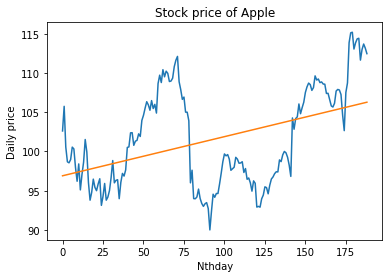

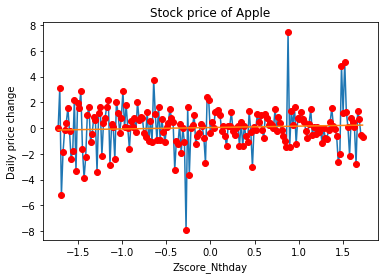

In [39]:
##This is a kernel of main function

data_source=Date_price_list(panel_data, start_date, end_date)
for x in range(0, data_source.len_period):
    tmp=Date_price(start_date+dtt.timedelta(days=x), panel_data['Open'][x], x)
    data_source.one_day_info.append(tmp)
    
func=Index_func(data_source)

plt.figure(1)##

plt.xlabel("Nthday")
plt.ylabel("Daily price")
plt.title("Stock price of Apple")
painter=Graph_plot(data_source, func)
painter.default()

func.linear_regression(show_fitness_index=True)
painter.liner_regression()
##

plt.figure(2)##
plt.xlabel("Zscore_Nthday")
plt.ylabel("Daily price change")
plt.title("Stock price of Apple")
func.Delta_y()
plt.plot(stats.zscore(data_source.date_x), func.delta_y)
plt.plot(stats.zscore(data_source.date_x), func.delta_y, "ro")

func.linear_regression(show_fitness_index=True, x=stats.zscore(data_source.date_x), y=func.delta_y)
painter.liner_regression()
##

plt.show()


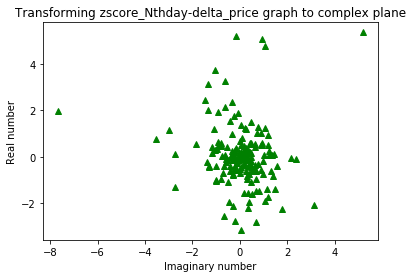

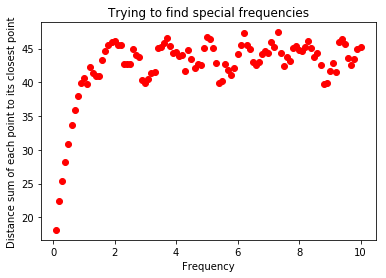

In [13]:
#The kernel is used for learning and research algorithm
def find_distance (x1, y1, x2, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5
def sum_dis_closest_p (x, y):
    sum=0;
    for i in range (0, len(x)):
        min_dis=find_distance(x[0],y[0], x[1], y[1])
        for j in range (0, len(x)):
            if (j != i):
                if (find_distance(x[i], y[i], x[j], y[j])<min_dis):
                    min_dis=find_distance(x[i], y[i], x[j], y[j])
        sum+=min_dis;
    return sum;

fq=1
z_x=stats.zscore(data_source.date_x)
z_x_max=np.max(z_x)
z_x_min=np.min(z_x)
pd=(z_x_max-z_x_min)/fq
theta=z_x/pd*np.pi
radius=func.delta_y
tmp_x=radius*np.cos(theta)
tmp_y=radius*np.sin(theta)
plt.figure(1)
plt.plot(tmp_x, tmp_y, "g^")
plt.xlabel("Imaginary number")
plt.ylabel("Real number")
plt.title("Transforming zscore_Nthday-delta_price graph to complex plane")
plt.show()

plt.figure(2)
plt.xlabel("Frequency")
plt.ylabel("Distance sum of each point to its closest point")
plt.title("Trying to find special frequencies")
for fq in range (0,100):
    fq=fq/10+0.1
    z_x=stats.zscore(data_source.date_x)
    z_x_max=np.max(z_x)
    z_x_min=np.min(z_x)
    pd=(z_x_max-z_x_min)/fq
    ##Let the x, y be in complex plane x+yi
    theta=z_x/pd*np.pi
    radius=func.delta_y
    tmp_x=radius*np.cos(theta)
    tmp_y=radius*np.sin(theta)
    plt.plot(fq, sum_dis_closest_p(tmp_x, tmp_y), "ro") ##|r|*(cosA+sinAi)=x+yi
plt.show()
